In [4]:
dataset_name = "W14_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
#            "BES_reduced",
#            "BESnumeric"
          ]

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

from IPython.display import display

import Jupyter_module_loader
from utility import display_components, display_pca_data, weighted_kde, setup_directories,\
                    get_manifest, get_small_files, clean_filename, create_subdir, amalgamate_waves

In [3]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()




In [5]:
# %%time
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

# dataset_filename = "BES2015_W8_v1.6.dta"

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
#     elif df=="BES_reduced_with_na":
#         globals()[df] = pd.read_msgpack(data_subfolder + "BES_reduced" + '.msgpack')
#         nans = pd.read_msgpack(data_subfolder + "nans" + '.msgpack')
#         globals()[df][nans] = np.nan
# #         globals()[df] = temp[nans]
#         del nans
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
#         globals()[df] = globals()[df].apply(pd.to_numeric,downcast='integer')
    print(df+":")
    globals()[df].info(memory_usage='deep')    
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

BES_Panel:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 73703 entries, 0 to 73702
Columns: 5692 entries, id to small_mii_catW10
dtypes: category(5483), datetime64[ns](31), float32(4), float64(154), int8(18), object(2)
memory usage: 506.4 MB
BES_reduced_with_na:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 73703 entries, 0 to 73702
Columns: 6864 entries, ageW1 to partyContactConW12_Yes
dtypes: float32(6864)
memory usage: 1.9 GB
var_type (5692, 13)


In [20]:
pd.__version__

'0.20.1'

In [ ]:
## immigSelf distribution by Leave/Remain

In [ ]:
# def amalgamate(df, pattern, forward_fill=True):
    
#     df_cols_dict = {int(re.search("W(\d+)", x).groups()[0]):x for x in df.columns if re.match(pattern, x)}
#     # sort volumns
#     df_cols = [df_cols_dict[x] for x in sorted(df_cols_dict.keys())]
#     # forward fill and and pick last column - or backward fill and pick first column
#     if forward_fill:
#         latest_series = df[df_cols].fillna(method="ffill",axis=1)[df_cols[-1]]
#     else:
#         latest_series = df[df_cols].fillna(method="bfill",axis=1)[df_cols[0]]
    
#     if df[df_cols[0]].dtype.name == "category":
#         latest_series = latest_series.astype(
#                     pd.api.types.CategoricalDtype(categories = df[df_cols[0]].cat.categories) )
#     return latest_series


In [6]:
[x for x in BES_reduced_with_na.columns if re.match("immigSelf", x)]

['immigSelfW7__Allow many more',
 'immigSelfW8__Allow many more',
 'immigSelfW9__Allow many more',
 'immigSelfW10__Allow many more',
 'immigSelfW11__Allow many more',
 'immigSelfW12__Allow many more',
 'immigSelfW14__Allow many more']

In [7]:
Leavers = BES_Panel["profile_eurefvote"] =="Leave the EU"
Remainers = BES_Panel["profile_eurefvote"] =="Stay/remain in the EU"

In [10]:
amalg_imm = amalgamate_waves(BES_reduced_with_na,"immigSelf",forward_fill=False)
euref_imm = amalgamate_waves(BES_reduced_with_na,"euRefVoteW",forward_fill=False)

In [11]:
amalg_imm.notnull().sum(),euref_imm.notnull().sum()

(56639, 69801)

In [12]:
prof_euref_imm = (BES_Panel["profile_eurefvote"]=="Leave the EU")
prof_euref_imm[BES_Panel["profile_eurefvote"]=="Don't know"] = np.nan

In [13]:
amalg_imm[euref_imm.notnull()].notnull().sum(), amalg_imm[prof_euref_imm.notnull()].notnull().sum()

(55233, 56296)

In [14]:
output_subfolder = BES_output_folder + os.sep + "Immigration_sentiment_by_euref" + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


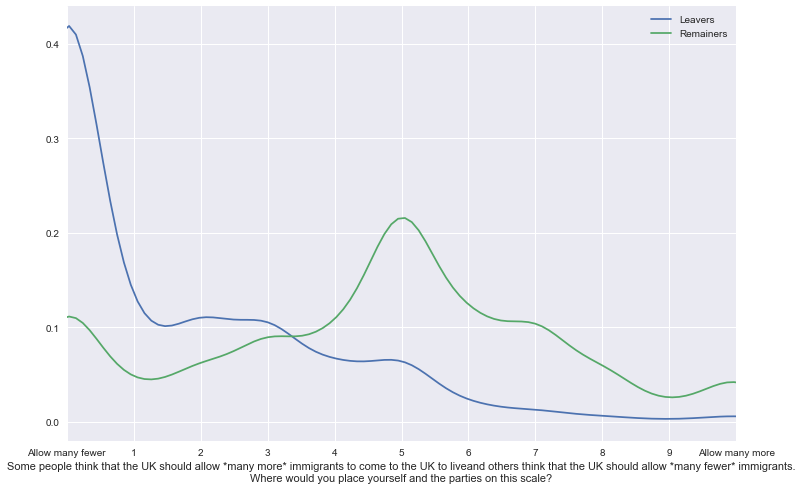

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))

Leave_imm =  amalg_imm[prof_euref_imm==1]
Remainer_imm = amalg_imm[prof_euref_imm==0]

sns.kdeplot(Leave_imm,     label="Leavers", bw=.5, ax = axes);#, cut=1);
sns.kdeplot(Remainer_imm,  label="Remainers", bw=.5, ax = axes);#, cut=1);

# ax.set_ylim([0,.2])
axes.set_xlim([0,10]);
axes.set_xticks(list(range(0,11)))
axes.set_xticklabels(BES_Panel["immigSelfW14"].cat.categories[0:11]);
axes.set_xlabel("Some people think that the UK should allow *many more* immigrants to come to the UK to live"+\
                "and others think that the UK should allow *many fewer* immigrants."+\
                "\nWhere would you place yourself and the parties on this scale?");

fname = output_subfolder + "Immigration_sentiment_by_euref" + ".png"
plt.savefig( fname, bbox_inches='tight' )

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


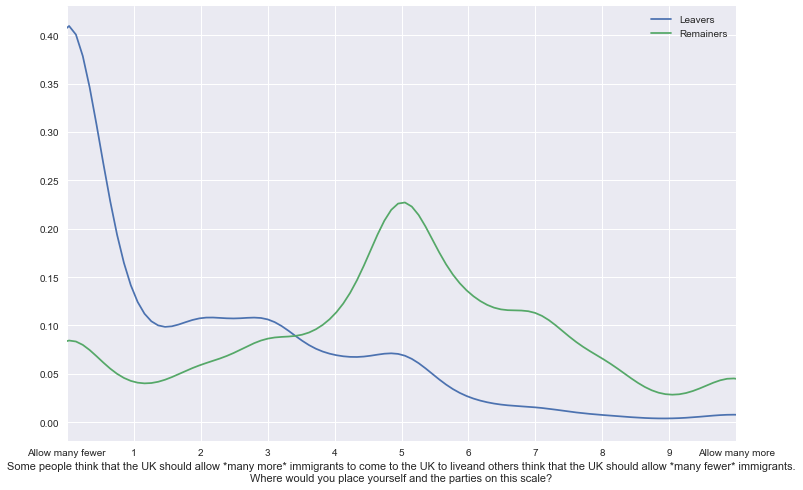

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))

Leave_imm =  amalg_imm[euref_imm==1]
Remainer_imm = amalg_imm[euref_imm==0]

sns.kdeplot(Leave_imm,     label="Leavers", bw=.5, ax = axes);#, cut=1);
sns.kdeplot(Remainer_imm,  label="Remainers", bw=.5, ax = axes);#, cut=1);

# ax.set_ylim([0,.2])
axes.set_xlim([0,10]);
axes.set_xticks(list(range(0,11)))
axes.set_xticklabels(BES_Panel["immigSelfW14"].cat.categories[0:11]);
axes.set_xlabel("Some people think that the UK should allow *many more* immigrants to come to the UK to live"+\
                "and others think that the UK should allow *many fewer* immigrants."+\
                "\nWhere would you place yourself and the parties on this scale?");

# fname = output_subfolder + "Immigration_sentiment_by_euref" + ".png"
# plt.savefig( fname, bbox_inches='tight' )

In [17]:
Leavers   = (BES_Panel['profile_eurefvote'] == "Leave the EU")
Remainers = (BES_Panel['profile_eurefvote'] == "Stay/remain in the EU")
amalgamated_euMIISmall = amalgamate_waves(BES_Panel, 'euMIISmallW', forward_fill=True)

TypeError: __new__() got an unexpected keyword argument 'categories'

In [19]:
pd.api.types.CategoricalDtype(categories = BES_Panel['profile_eurefvote'].cat.categories)

TypeError: __new__() got an unexpected keyword argument 'categories'

In [ ]:
sovereignty = "Sovereignty/EU bureaucracy"
immigration = "Immigration"
SovOrImmLeavers = Leavers&amalgamated_euMIISmall.notnull()

Sov = amalgamated_euMIISmall[SovOrImmLeavers]
BES_sov = BES_reduced[SovOrImmLeavers]
drop_vars = [x for x in BES_reduced.columns if ("euRefVote" in x) or ("profile_eurefvote" in x)\
             or ("euMII" in x) or ("EUMII" in x)]
BES_sov = BES_sov.drop(drop_vars , axis=1)
